https://bastings.github.io/annotated_encoder_decoder/?utm_campaign=NLP%20News&utm_medium=email&utm_source=Revue%20newsletter

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace
from torchtext import data, datasets
import spacy

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: False
cuda:0


In [3]:
class EncoderDecoder(nn.Module):
    """
    Standard Encoder-Decoder
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        encoder_hidden, encoder_final = self.encode(src, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_lengths):
        return self.encoder(self.src_embed(src), src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
              decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                           src_mask, trg_mask, hidden=decoder_hidden)
    
class Generator(nn.Module):
    """Define standard linear + softmax generation step"""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), -1)

## Encoder

Use bi-direction GRU

For efficiency, we need to support mini-batches. Sentences may have different lengths, so unroll differently. 

pack_padded_sequence - Packs a Tensor containing padded sequences of variable length
pad_packed_sequence - undoes the pack_padded_sequence

In [4]:
class Encoder(nn.Module):
    """encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers,
                         batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, lengths):
        """
        Applies a bi-directional GRU to sequence of embeddings X
        The input mini-batch x needs to be sorted by length
        x should have dimensions [batch, seq_length, input_size]
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        # final shape: (num_layers * num_directions, batch, hidden_size)
        # the first dimension will be a multiple of 2 when bi-directional
        # for example, with num_layers = 2, then first dimension is 4
        # the 0th and 2st rows and the final forwards and
        # the 1st and 3rd rows the final backwards 
        hidden, final = self.rnn(packed)
        # also returns the lengths
        # shape of hidden: (batch, seq_length, num_directions*hidden size)
        hidden, _ = pad_packed_sequence(hidden, batch_first=True)
        
        #get all final forwards
        fwd_final = final[0:final.size(0):2]
        #get all final backwards
        bwd_final = final[1:final.size(0):2]
        # shape of final: (num layers, batch, 2*hidden_size)
        final = torch.cat([fwd_final, bwd_final], dim=2)
        
        return hidden, final

## Decoder

We will always use teacher forcing

Encoder Final is the last hidden state used to initalize first hidden state of decoder

In [5]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
        
        # will concat the previous word embedding with the context
        # where the context is the weighted sum of the encoder hidden states
        # which has a size of 2 * hidden
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout)
        # to initalize from the final encoder state
        # need to project because goes from bi-directional size to one direction
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None
        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                         hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Preform a single decoder step - 1 word"""
        
        # this is the hidden state for the decoder
        query = hidden[-1].unsqueeze(1) # takes the last layer. shape: [batch, 1, hidden_dimension]
        context, _ = self.attention(query=query, proj_key=proj_key,
                                            value=encoder_hidden, mask=src_mask)
        
        # process the concat of the prev_embedding and the context (attention)
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        # use the prev_embed, output from GRU, and context to get final vector of hidden_size
        # which will be used to generated probabilities across our vocabulary
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)
        
        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, src_mask, trg_mask,
               hidden=None, max_len=None):
        """Unroll the encoder 1 step at a time"""
        
        if max_len is None:
            max_len = trg_mask.size(-1)
            
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
            
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        # projects them to hidden_dimension size
        proj_key = self.attention.key_layer(encoder_hidden)
        
        decoder_states = []
        pre_output_vectors = []
    
        
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(prev_embed,
                                                          encoder_hidden,
                                                          src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)
            
        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        # all we really use are the pre_output_vectors
        return decoder_states, hidden, pre_output_vectors # [B,N,D]

    def init_hidden(self, encoder_final):
        """Returns the intial decoder state, conditioned on final encoder state"""
        if encoder_final is None:
            return None #start with zeros
        else:
            return torch.tanh(self.bridge(encoder_final))

## Attention

At every time step, decoder has **ALL** the source word hidden states. Attention allows it to learn which are the most relevant. 

The state of the decoder is represented by the hidden state.

We will use an MLP-based, additive attention with tanh activation.

**Decoder state:** is the query
**The encoder states:** the key

We add the query to all of the keys and pass them through a tanh function then project them to a single number (the **energy**).

We then mask out invalid positions and apply softmax to get probability distribution across the words.

We then take a weighted sum of the encoder hidden states, where the weights are the probabilities. This is the **context.**

In [6]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # assume bi-directional encoder 
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size
        
        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"
        
        # project the query to hidden_size (this already done for keys)
        query = self.query_layer(query)
        
        # Calculate energies
        # pytorch broadcasts the query to all the keys with the addition
        # shape batch x seq_length x 1
        scores = self.energy_layer(torch.tanh(query + proj_key))
        # batch x 1 x seq_length
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        # the mask is broadcastable b/c it is of size seq_length
        # see: https://pytorch.org/docs/stable/notes/broadcasting.html#broadcasting-semantics
        # the softmax will set all negative inf values to zero
        # thus wont be used in weighted value
        # which is appropriate since they are padding values
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # turn scores into probabilities
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas
        
        # context is weighted sum of the values (the original encoder hidden states)
        context = torch.bmm(alphas, value)
        
        # context shape: batch x 1 x key size
        # alpha shape: batch x 1 x mask length
        return context, alphas

## English to French Translation

In [29]:
spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')

def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
LOWER = True

MAX_LEN = 25
MIN_FREQ = 5

### Set up fields and load in data

In [30]:
SRC = data.Field(tokenize=tokenize_de, batch_first=True, lower=LOWER, 
                  include_lengths=True, unk_token=UNK_TOKEN, 
                  pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    
TRG = data.Field(tokenize=tokenize_en, batch_first=True, lower=LOWER, 
                 include_lengths=True, unk_token=UNK_TOKEN, 
                 pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

In [31]:
def data_filter(x):
    len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

train_data, valid_data, test_data = datasets.IWSLT.splits(exts=('.fr', '.en'), 
                                    fields=(SRC, TRG), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)

downloading fr-en.tgz


fr-en.tgz: 100%|██████████| 25.7M/25.7M [00:15<00:00, 1.72MB/s]


.data/iwslt/fr-en/IWSLT16.TED.dev2010.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2012.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2013.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2010.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2010.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2014.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2014.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.dev2010.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2013.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2012.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2011.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2011.fr-en.en.xml
.data/iwslt/fr-en/train.tags.fr-en.fr
.data/iwslt/fr-en/train.tags.fr-en.en


In [32]:
SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

### Batching

Use bucketIterator which will group sentences by close to same length as possible. For efficiency, pytorch requires batches sorted by length.

In [33]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True,
                                sort_within_batch=True,
                                sort_key=lambda x: (len(x.src), len(x.trg)),
                                repeat=False, device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, 
                           repeat=False, device=DEVICE)

In [34]:
class Batch:
    """
    Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        # the bucket iterator returns a tuple of (src, src_lengths)
        # shape of src: bxmax length
        # shape of src_lengths: b
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        # shape: b x 1 x max_length
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None
        
        if trg is not None:
            trg, trg_lengths = trg
            # -1 b/c these are the inputs
            self.trg = trg[:,:-1]
            self.trg_lengths = trg_lengths
            # 1 b/c these the what we will predict
            self.trg_y = trg[:, 1:]
            # shape: b x max length
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()

        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()
            
            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                
def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

## Loss


In [35]:
class SimpleLossCompute:
    
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        # get log_softmax over the vocab
        # shape x: batch x seq_length x vocab_size
        # shape y: batch x seq_length (the truth)
        x = self.generator(x)
        
        # our nllloss expects the x input to be NxC where C is the vocab size
        # and y input to be N
        # so we flatten them out
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

## Tracking and Printing

In [36]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        # encode the src
        encoder_hidden, encoder_final = model.encode(src, src_lengths)
        # prev_y starts as sos_index 
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        # the target mask is all ones b/c all valid
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    # this will never happen in our use case
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
        
        # get numpy versions of tensors
        # trg is trg_y b/c that's the truth and already skips the SOS token
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break

## Training

In [37]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model


def run_epoch(data_iter, model, loss_compute, print_every=50):
    
    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0
    
    for i, batch in enumerate(data_iter, 1):
        
        _, _, pre_output = model.forward(batch.src, batch.trg,
                                        batch.src_mask, batch.trg_mask,
                                        batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0
            
    return math.exp(total_loss / float(total_tokens))

def train(model, num_epochs=10, lr=0.0003, print_every=100):
    
    if USE_CUDA:
        model.cuda()
        
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []
    
    for epoch in range(num_epochs):
        print("Epoch", epoch)
        model.train()
        # we using () as a generator comprehension
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter),
                                     model,
                                     SimpleLossCompute(model.generator,
                                                      criterion,
                                                      optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities

## Run everything

In [38]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=500)

/home/tyler/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 500 Loss: 38.328526 Tokens per Sec: 19878.745069
Epoch Step: 1000 Loss: 74.257416 Tokens per Sec: 19896.994471
Epoch Step: 1500 Loss: 86.251877 Tokens per Sec: 20215.667041
Epoch Step: 2000 Loss: 97.226913 Tokens per Sec: 20009.305914

Example #1
Src :  j'ai travaillé pour une ong italienne et chaque projet que nous avons monté en afrique a échoué .
Trg :  i worked for an italian ngo , and every single project that we set up in africa failed .
Pred:  i took a <unk> for a <unk> and every single that we 've been in africa .

Example #2
Src :  et j'étais vraiment bouleversé .
Trg :  and i was <unk> .
Pred:  and i was really .

Example #3
Src :  je pensais , à 21 ans , que nous les italiens étions des gens biens et que nous faisions du bon travail en afrique .
Trg :  i thought , age 21 , that we italians were good people and we were doing good work in africa .
Pred:  i was , i was the <unk> , we 're going to do people who are going to be able to be able to work .

Valid

Validation perplexity: 8.611184
Epoch 8
Epoch Step: 500 Loss: 16.236769 Tokens per Sec: 19531.470778
Epoch Step: 1000 Loss: 21.538202 Tokens per Sec: 19778.229386
Epoch Step: 1500 Loss: 30.669321 Tokens per Sec: 20148.839575
Epoch Step: 2000 Loss: 22.319052 Tokens per Sec: 19793.007229

Example #1
Src :  j'ai travaillé pour une ong italienne et chaque projet que nous avons monté en afrique a échoué .
Trg :  i worked for an italian ngo , and every single project that we set up in africa failed .
Pred:  i 've been working for a chicken and every single project that we 've mounted in africa has failed .

Example #2
Src :  et j'étais vraiment bouleversé .
Trg :  and i was <unk> .
Pred:  and i was really upset .

Example #3
Src :  je pensais , à 21 ans , que nous les italiens étions des gens biens et que nous faisions du bon travail en afrique .
Trg :  i thought , age 21 , that we italians were good people and we were doing good work in africa .
Pred:  i thought , in 21 years , we were maki

## prediction and evaluation

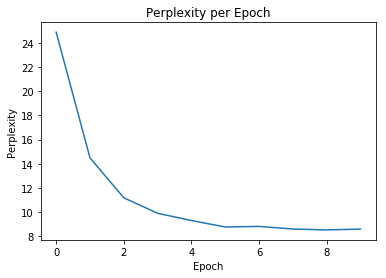

In [39]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

plot_perplexity(dev_perplexities)

In [40]:
import sacrebleu

In [41]:
references = [" ".join(example.trg) for example in valid_data]

In [42]:
references[-1]

'thank you .'

In [43]:
# convert german into english using model

In [44]:
hypotheses = []
alphas = []
for batch in valid_iter:
    batch = rebatch(PAD_INDEX, batch)
    pred, attention = greedy_decode(model, batch.src, batch.src_mask,
                                   batch.src_lengths, max_len=25,
                                   sos_index=TRG.vocab.stoi[SOS_TOKEN],
                                   eos_index=TRG.vocab.stoi[EOS_TOKEN])
    hypotheses.append(pred)
    alphas.append(attention)

In [45]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses = [" ".join(x) for x in hypotheses]

In [46]:
hypotheses[-1]

'thank you .'

In [47]:
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score

In [48]:
print(bleu)

29.3957473423028


## plot attention

In [49]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()


src ['et', 'puis', 'il', 'faut', 'leur', 'dire', 'la', 'vérité', 'sur', "l'entrepreneuriat", '.', '</s>']
ref ['and', 'then', 'you', 'have', 'to', 'tell', 'them', 'the', 'truth', 'about', 'entrepreneurship', '.', '</s>']
pred ['and', 'then', 'you', 'have', 'to', 'tell', 'them', 'the', 'truth', 'about', 'entrepreneurship', '.', '</s>']


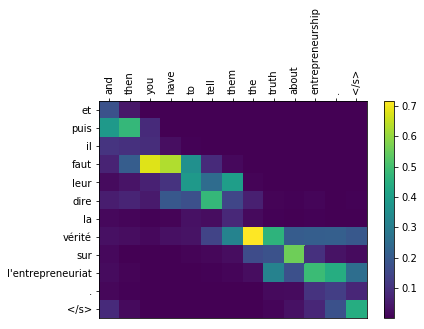

In [52]:
idx = 75
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
# [0] b/c only 1 row
# .T to get src as rows
# then limit columns to length of predicted to fit
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)